#OCR-Based Image Captioning Model
## References:
- https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/seq2seq_transformer/seq2seq_transformer.py
- https://colab.research.google.com/drive/1EYUxzhBF5Tr5GxY7QxOGopuwacniMhS1#scrollTo=pcbCQqrDnJ4- 
- https://colab.research.google.com/drive/1rKqfTMOZGiLz584GSUPguRun0Vz6zpK9?usp=sharing#scrollTo=pEuTbyGcKEcQ 
- Huggingface_examples.ipynb from class 

In [ ]:
# References:
# https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/seq2seq_transformer/seq2seq_transformer.py
# https://colab.research.google.com/drive/1EYUxzhBF5Tr5GxY7QxOGopuwacniMhS1#scrollTo=pcbCQqrDnJ4-
# https://colab.research.google.com/drive/1rKqfTMOZGiLz584GSUPguRun0Vz6zpK9?usp=sharing#scrollTo=pEuTbyGcKEcQ
# Huggingface_examples.ipynb from class 

In [ ]:
import torch 
torch.multiprocessing.set_start_method('spawn')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# !wget https://dl.fbaipublicfiles.com/textvqa/data/textcaps/TextCaps_0.1_train.json
# !wget https://dl.fbaipublicfiles.com/textvqa/data/textcaps/TextCaps_0.1_val.json
# !wget https://dl.fbaipublicfiles.com/textvqa/images/train_val_images.zip

In [ ]:
# !pip install transformers
# !pip install easyocr

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchtext.data.metrics import bleu_score

In [ ]:
import json
from torch.utils.data import Dataset, DataLoader
import easyocr
reader = easyocr.Reader(['en'])

In [ ]:
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms

class TextCapsDataset(Dataset):
    def __init__(self, 
                 root_dir, 
                 json_file,
                 ):
        self.root_dir = root_dir
        self.json_file = json_file
        self.data = []
        with open(json_file, 'r') as f:
            json_data = json.load(f)
            for item in json_data['data']:
                image_id = item['image_id']
                caption_str = item['caption_str']
                self.data.append((image_id, caption_str))

    def __getitem__(self, index):
        image_id, caption_str = self.data[index]
        image_pth = self.root_dir + image_id + ".jpg"
        try: 
            image = Image.open(image_pth).convert("RGB")
        except FileNotFoundError:
            print(f"Could not open image {image_pth}")
            return None

        ocr_lst = reader.readtext(image_pth)
        # do not accept captions with confidence level less than 0.3
        confidence_limit = 0.5
        # TODO: should size matter? rank the OCR boxes size and pick the top 10?
        text_lst = [ocr[1] for ocr in ocr_lst if ocr[2] > 0.3]
        text = '  '.join(text_lst)

        return {
                "image": image,
                "text": text,
                "caption": caption_str
        }

    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = TextCapsDataset("./data/train_images/", "./data/TextCaps_0.1_train.json")
eval_dataset = TextCapsDataset("./data/train_images/", './data/TextCaps_0.1_val.json')

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 109765
Number of validation examples: 15830


In [ ]:
print(train_dataset[100]["image"])
print(train_dataset[100]["text"])
print(train_dataset[100]["caption"])

<PIL.Image.Image image mode=RGB size=768x1024 at 0x7F3E5B0E68B0>
4u3  To  Be a part of  McDonald's"  Junior Otters Kids Club!  As a McDonald's Junior Otters  Club member;  youll  six free game tickets, a club T-Shirt  and lots of other cool stuffl Over a $80 valuel  also a Kids Club Party in February at  Eastway Lanes: Join Todayl  Pick up your registration form  at any home game or call   the Erie Otters office:  imlovin'It"  WWWottershockeycom  JOINI  Kids  get  There"
A posted sign in the window shows how to join the McDonald's Junior Otters Kids Club.


In [ ]:
import random
train_subset_ind = random.sample(range(0,len(train_dataset)), 10000)
eval_subset_ind = random.sample(range(0,len(eval_dataset)), 1500)

train_subset = torch.utils.data.Subset(train_dataset, train_subset_ind)
eval_subset = torch.utils.data.Subset(eval_dataset, eval_subset_ind)

In [ ]:
print("Number of training examples:", len(train_subset))
print("Number of validation examples:", len(eval_subset))

Number of training examples: 10000
Number of validation examples: 1500


In [ ]:
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
import torchvision.transforms as T

max_length = 50
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

image_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
image_encoder = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

for p in image_encoder.parameters():
    p.requires_grad = False

image_encoder.to(device)

In [ ]:
# check dimensions of image_embedding
# image_inputs = image_processor(train_dataset[0]["image"], return_tensors="pt")
# image_inputs = {k:v.to(device) for k,v in image_inputs.items()}
# image_outputs = image_encoder(**image_inputs)
# image_embedding = image_outputs.pooler_output
# print(image_embedding.shape) # prints torch.Size([1, 768])

In [ ]:
def collate_fn(batch):
    image_inputs = image_processor([x["image"] for x in batch], return_tensors="pt")
    image_inputs = {k:v.to(device) for k,v in image_inputs.items()}
    image_outputs = image_encoder(**image_inputs)
    image_embedding = image_outputs.last_hidden_state
    image_embedding = image_embedding.detach()
   
    text_tok = tokenizer([x["text"] for x in batch], return_tensors="pt", padding='max_length', truncation=True, max_length=max_length)
    text_tok = {k:v.to(device) for k,v in text_tok.items()}

    caption_tok = tokenizer([x["caption"] for x in batch], return_tensors="pt", padding='max_length', truncation=True, max_length=max_length+2)
    caption_tok = {k:v.to(device) for k,v in caption_tok.items()}

    return {
                "image_emb": image_embedding,
                "text_tok": text_tok,
                "caption_tok": caption_tok
    }

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
eval_batch_size = 32
num_workers = 0

train_dataloader = torch.utils.data.DataLoader(
    train_subset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=num_workers, 
    collate_fn=collate_fn,
)
eval_dataloader = torch.utils.data.DataLoader(
    eval_subset, 
    batch_size=eval_batch_size,
    shuffle=True, 
    num_workers=num_workers, 
    collate_fn=collate_fn,
)

In [ ]:
for batch in train_dataloader:
    break
print(batch["image_emb"].shape)
print(batch["text_tok"]["input_ids"].shape) # padded with zeros until max_length
print(batch["caption_tok"]["input_ids"].shape) # padded with zeros until max_length

torch.Size([32, 197, 768])
torch.Size([32, 50])
torch.Size([32, 52])


In [ ]:
print(batch["text_tok"]["input_ids"][1]) # padded with zeros until max_length
print(batch["caption_tok"]["input_ids"][1]) # padded with zeros until max_length
# start token id is 101 and end token id is 102

tensor([  101,  4895,  1058,  2140,  1010,  1057,  2368,  2232, 10722, 11001,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
       device='cuda:0')
tensor([ 101, 1996, 2773, 2767, 2003, 2012, 1996, 2327, 1997, 1996, 2317, 2338,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], device='cuda:0')


In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        image_seq_len,
        image_size,
        vocab_size,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()

        self.text_word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.text_position_embedding = nn.Embedding(max_len, embedding_size)
        self.image_type_embedding = nn.Embedding(2, embedding_size) # just 2 for image and for text


        self.cap_word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.cap_position_embedding = nn.Embedding(max_len+1, embedding_size)

        self.image_position_embedding = nn.Embedding(image_seq_len, embedding_size)

        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        self.fc_img = nn.Linear(image_size, embedding_size)
        self.fc_out = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, image, text, cap):
        N, text_seq_length = text['input_ids'].shape
        N, cap_seq_length = cap['input_ids'].shape
        N, img_seq_length, img_size = image.shape

        text_positions = (
            torch.arange(0, text_seq_length)
            .unsqueeze(1)
            .expand(text_seq_length, N)
            .to(self.device)
        )

        embed_text = self.dropout(
            (self.text_word_embedding(text['input_ids'].transpose(0,1)) + self.text_position_embedding(text_positions))
        )

        image = self.fc_img(image) 

        image_positions = (
            torch.arange(0, img_seq_length)
            .unsqueeze(1)
            .expand(img_seq_length, N)
            .to(self.device)
        )

        embed_image = self.dropout(
            (image.transpose(0,1) + self.image_type_embedding(torch.ones((img_seq_length, N), dtype=torch.int64).to(self.device)) + self.image_position_embedding(image_positions))
        )

        embed_input = torch.cat([embed_text, embed_image], 0)

        text_padding_mask = text['attention_mask'] == 0
        image_padding_mask = torch.LongTensor([0] * embed_image.shape[0]).repeat(embed_image.shape[1], 1).to(self.device)
        extended_padding_mask = torch.cat([text_padding_mask, image_padding_mask], 1).bool()

        cap_positions = (
            torch.arange(0, cap_seq_length)
            .unsqueeze(1)
            .expand(cap_seq_length, N)
            .to(self.device)
        )

        embed_cap = self.dropout(
            (self.cap_word_embedding(cap['input_ids']).transpose(0,1) + self.cap_position_embedding(cap_positions))
        )
        
        cap_mask = self.transformer.generate_square_subsequent_mask(cap_seq_length).to(self.device)
        tgt_key_padding_mask = cap['attention_mask'] == 0

        out = self.transformer(
            embed_input,
            embed_cap,
            src_key_padding_mask=extended_padding_mask,
            tgt_mask=cap_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )

        out = self.fc_out(out)

        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_model = False
save_model = True

# Training hyperparameters
num_epochs = 10
learning_rate = 3e-4
batch_size = 32

# Model hyperparameters
vocab_size = tokenizer.vocab_size
embedding_size = 512
image_seq_len = 197
image_size = 768
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.10
max_len = 50
forward_expansion = 4
start_token_id = 101
end_token_id = 102

In [ ]:
model = Transformer(
    embedding_size,
    image_seq_len,
    image_size,
    vocab_size,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

In [ ]:
def get_model_info(model):
    # Compute number of trainable parameters in the model
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Compute the size of the model in MB
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    size_all_mb = (param_size + buffer_size) / 1024**2
    
    return num_params, size_all_mb

In [ ]:
# Print model info
num_params, size_all_mb = get_model_info(model)

print("Number of trainable params:", num_params)
print('Model size: {:.3f}MB'.format(size_all_mb))

Number of trainable params: 56960338
Model size: 217.286MB


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=10, verbose=True
)

pad_idx = 0
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [ ]:
def create_caption(model, image, text, device, max_length=50): # tokenized version
    image_inputs = image_processor(image, return_tensors="pt")
    image_inputs = {k:v.to(device) for k,v in image_inputs.items()}
    image_outputs = image_encoder(**image_inputs)
    image_embedding = image_outputs.last_hidden_state
    image_embedding = image_embedding.detach().to(device)

    text_tok = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=max_length)
    text_tok = {k:v.to(device) for k,v in text_tok.items()} 

    # create token from image and caption
    outputs = ""
    outputs = tokenizer(outputs, return_tensors="pt", padding='max_length', truncation=True, max_length=51)
    outputs = {k:v.to(device) for k,v in outputs.items()} 
    eos_ind = outputs["input_ids"]==102
    outputs["input_ids"][eos_ind] = 0 # change eos to pad token
    outputs["attention_mask"][eos_ind] = 0 # change to pad token for attention_mask

    sequence = [101]

    for i in range(max_length):
        with torch.no_grad():
            cap_out = model(image_embedding, text_tok, outputs)
        best_guess = cap_out.argmax(2)[i, :]
        outputs["input_ids"][:,i+1] = best_guess
        outputs["attention_mask"][:,i+1] = 1

        sequence.append(best_guess)

        if best_guess == 102:
            break

    created_caption = tokenizer.convert_ids_to_tokens(sequence, skip_special_tokens=True)
    return created_caption

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def show_image_and_caption(ind, dataset, model): 
    data = dataset[ind]
    plt.axis("off")
    plt.imshow(data["image"])
    plt.show()
    caps_created = create_caption(model, data["image"], data["text"], device)
    print("captions created by model:", caps_created)

    caption_tok = tokenizer(data["caption"], return_tensors="pt", padding='max_length', truncation=True, max_length=max_length+2)
    caption_tok = {k:v.to(device) for k,v in caption_tok.items()}
    true_caption = tokenizer.convert_ids_to_tokens(caption_tok["input_ids"].tolist()[0], skip_special_tokens=True)
    print("true captions from dataset:", true_caption)

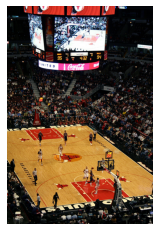

captions created by model: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
true captions from dataset: ['basketball', 'game', 'with', '4', ':', '32', 'left', 'in', 'the', 'quarter', '.']


In [ ]:
show_image_and_caption(10112, train_dataset, model)

[Epoch 0 / 9]


  0%|          | 0/313 [00:00<?, ?it/s]

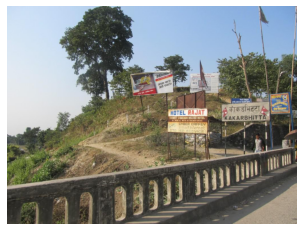

captions created by model: ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
true captions from dataset: ['a', 'sign', 'that', 'says', 'the', 'word', 'hotel', 'on', 'it']


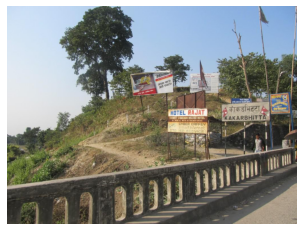

captions created by model: ['a', 'a', 'a', 'a', 'a']
true captions from dataset: ['a', 'sign', 'that', 'says', 'the', 'word', 'hotel', 'on', 'it']


KeyboardInterrupt: ignored

In [ ]:
from tqdm.notebook import tqdm
dataloaders = [eval_dataloader, train_dataloader]
datasets = [eval_subset, train_subset]

img_ind = 21

for epoch in range(0,num_epochs):
    print(f"[Epoch {epoch} / {num_epochs-1}]")
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        losses = []

        for batch_id, batch in enumerate(tqdm(dataloaders[phase == 'train'])):
            image = batch["image_emb"]
            text = batch["text_tok"]
            cap = batch["caption_tok"]
            cap_in = {k:v.clone().detach() for k,v in cap.items()}

            cap_in["input_ids"][cap["input_ids"]==end_token_id] = 0 # change eos to pad token
            cap_in["input_ids"] = cap_in["input_ids"][:,:-1] # reduce by a dim
            cap_in["attention_mask"][cap["input_ids"]==end_token_id] = 0 # change to pad token for attention_mask
            cap_in["attention_mask"] = cap_in["attention_mask"][:,:-1] # reduce by a dim
 
            output = model(image, text, cap_in)

            # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
            # doesn't take input in that form. For example if we have MNIST we want to have
            # output to be: (N, 10) and targets just (N). Here we can view it in a similar
            # way that we have output_words * batch_size that we want to send in into
            # our cost function, so we need to do some reshapin.
            # Let's also remove the start token while we're at it
            output = output.reshape(-1, output.shape[2])
            target = cap['input_ids'][:,1:].reshape(-1)

            optimizer.zero_grad()

            loss = criterion(output, target)
            losses.append(loss.item())

            loss.backward()
            # Clip to avoid exploding gradient issues, makes sure grads are
            # within a healthy range
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            # Gradient descent step
            optimizer.step()

            if batch_id % 20 == 0 and phase == 'train':
                show_image_and_caption(img_ind, datasets[phase == 'train'], model)

        mean_loss = sum(losses) / len(losses)
        print(f'{phase} Mean Loss: {mean_loss:.4f}')

        if phase == 'train':
            scheduler.step(mean_loss)

    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
    save_checkpoint(checkpoint, f'./model_weights/new/epoch{epoch}.pth.tar')

    print()